## CNN with Dropout and Data augmentation

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
# define parameters

batch_size = 32 
img_height = 180 
img_width = 180 

#path
path = 'archive-2/architectural-styles-dataset'

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=123,          # 123 is aribtary, could be any integer. 
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 10113 files belonging to 25 classes.
Using 8091 files for training.


2023-04-25 13:59:28.188279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    path, 
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width), 
    batch_size=batch_size
)

Found 10113 files belonging to 25 classes.
Using 2022 files for validation.


In [7]:
# class_names
class_names = train_ds.class_names
print(class_names)

['Achaemenid architecture', 'American Foursquare architecture', 'American craftsman style', 'Ancient Egyptian architecture', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture', 'Bauhaus architecture', 'Beaux-Arts architecture', 'Byzantine architecture', 'Chicago school architecture', 'Colonial architecture', 'Deconstructivism', 'Edwardian architecture', 'Georgian architecture', 'Gothic architecture', 'Greek Revival architecture', 'International style', 'Novelty architecture', 'Palladian architecture', 'Postmodern architecture', 'Queen Anne architecture', 'Romanesque architecture', 'Russian Revival architecture', 'Tudor Revival architecture']


### Visualize the data

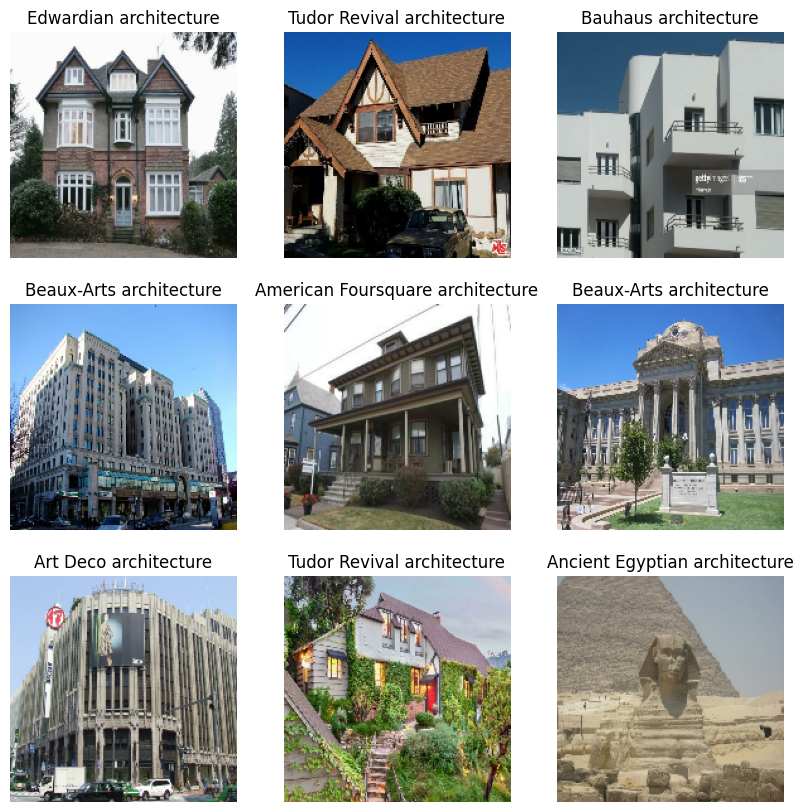

In [8]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


### Configure the dataset for performance 


In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# These lines speeds up the training process. Caching ensures that we don't have to reload the data every time we use it.
# Prefetching ensures that we always have the next batch of data ready to go. 

### Standardize the data 

In [10]:
normalization_layer = layers.Rescaling(1./255)

### Create model

In [11]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #  need to check if another one is better. 
              metrics = ['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train model

In [14]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10


2023-04-25 14:01:04.573737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 150 of 1000
2023-04-25 14:01:11.681763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


253/253 [==============================] - 105s 343ms/step - loss: 3.0363 - accuracy: 0.1132 - val_loss: 2.7802 - val_accuracy: 0.1919
Epoch 2/10
253/253 [==============================] - 83s 329ms/step - loss: 2.6493 - accuracy: 0.2096 - val_loss: 2.5816 - val_accuracy: 0.2211
Epoch 3/10
253/253 [==============================] - 83s 324ms/step - loss: 2.3139 - accuracy: 0.3017 - val_loss: 2.4672 - val_accuracy: 0.2621
Epoch 4/10
253/253 [==============================] - 83s 324ms/step - loss: 1.8974 - accuracy: 0.4284 - val_loss: 2.4595 - val_accuracy: 0.2868
Epoch 5/10
253/253 [==============================] - 81s 318ms/step - loss: 1.3533 - accuracy: 0.5886 - val_loss: 2.6042 - val_accuracy: 0.2967
Epoch 6/10
253/253 [==============================] - 80s 315ms/step - loss: 0.7183 - accuracy: 0.7828 - val_loss: 3.3128 - val_accuracy: 0.2908
Epoch 7/10
253/253 [==============================] - 81s 317ms/step - loss: 0.2887 - accuracy: 0.9228 - val_loss: 4.0091 - val_accuracy: 0.

### Visualize training results

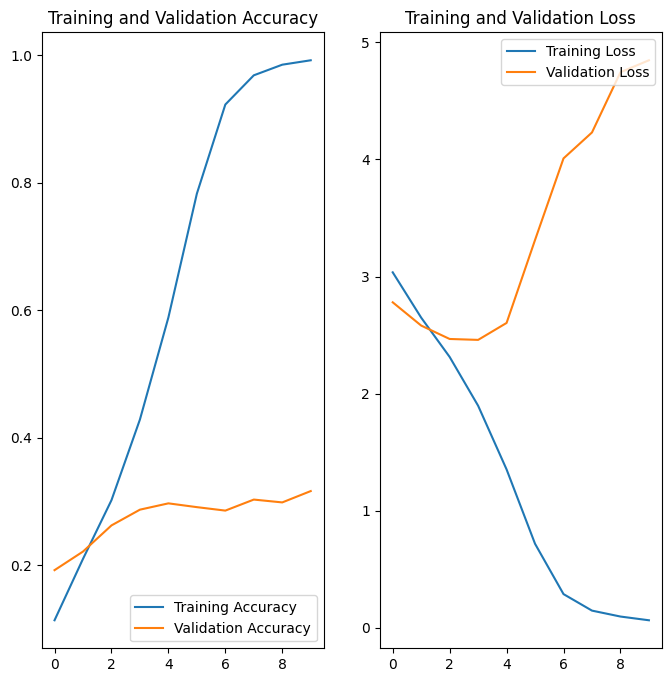

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Only around 30 % accuracy. Sign of overfitting, since the training accuacy increase linarly in time, but the validation accuracy is around 30 % for a long time. We can use transfer learning, add dropout and data augumentation. 

### Data augmentation

In [17]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    #layers.RandomBrightness(0.1),
    #layers.RandomContrast(0.1)  # unsure how big effect contrast and brightness has(??)
]  
)
# Here we can add a lot more of them and see what works best.

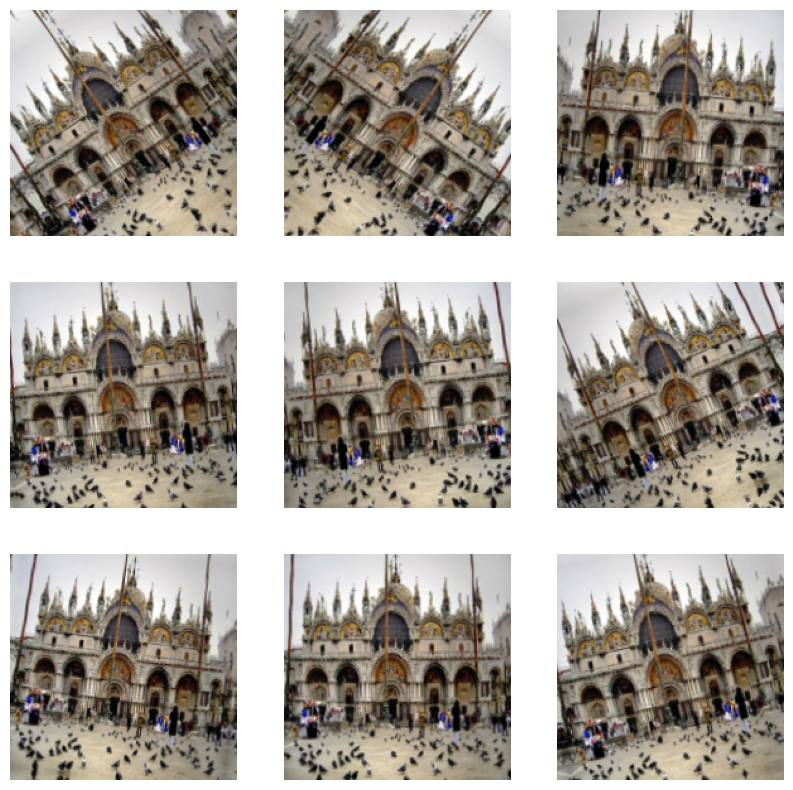

In [18]:
# visulaize a random image with data augmentaion 
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create a new model with dropout using the augmented data

In [20]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [21]:
# Compile and train model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
253/253 [==============================] - 111s 432ms/step - loss: 3.1212 - accuracy: 0.0876 - val_loss: 3.0359 - val_accuracy: 0.1355
Epoch 2/15
253/253 [==============================] - 104s 410ms/step - loss: 2.8573 - accuracy: 0.1562 - val_loss: 2.9108 - val_accuracy: 0.1686
Epoch 3/15
253/253 [==============================] - 126s 497ms/step - loss: 2.6624 - accuracy: 0.1968 - val_loss: 2.5931 - val_accuracy: 0.2151
Epoch 4/15
253/253 [==============================] - 114s 449ms/step - loss: 2.5283 - accuracy: 0.2372 - val_loss: 2.4708 - val_accuracy: 0.2626
Epoch 5/15
253/253 [==============================] - 130s 514ms/step - loss: 2.4247 - accuracy: 0.2704 - val_loss: 2.5501 - val_accuracy: 0.2512
Epoch 6/15
253/253 [==============================] - 109s 431ms/step - loss: 2.3397 - accuracy: 0.2895 - val_loss: 2.7158 - val_accuracy: 0.2409
Epoch 7/15
253/253 [==============================] - 107s 422ms/step - loss: 2.3048 - accuracy: 0.3079 - val_loss: 2.4644 -

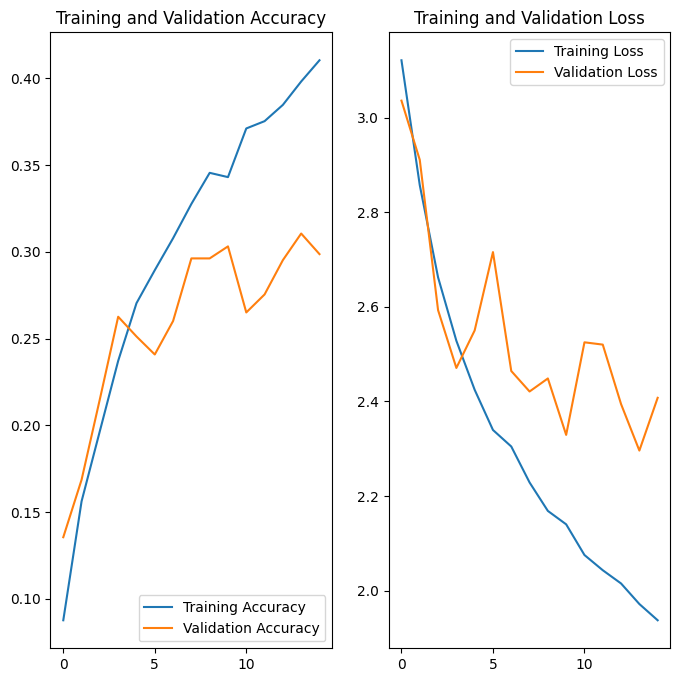

In [23]:
# results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

More equal results, but need to find the best dropout and augmentations. 
And use transfer learning. 
